# Exercise 6 - Pixel classification and object segmentation

### Imports and fuctions

In [144]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom 
from scipy.stats import norm
from scipy.spatial import distance


def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

## Exercises lecture

### Minimum distance

**Minimum distance** only cares about the mean, not the "spread"

### Exercise 1

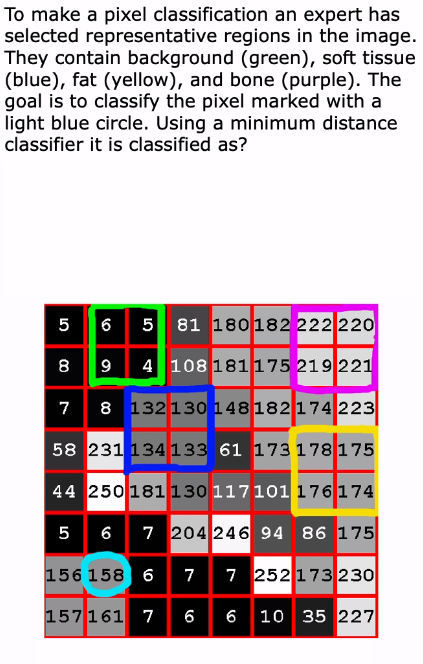

In [2]:
green = [6,5,9,4]
blue = [132, 130, 134, 133]
yellow = [178, 175, 176, 174]
purple = [222,220,219,221]

# Find mean
clusters = [green, blue, yellow, purple]
mean_clusters = [np.mean(i) for i in clusters]
print('The mean of the clusters is:', mean_clusters)

# Define the point we want to classify
new_point = 158

# Find the minimum distance
dist_to_point = [np.abs(new_point-i) for i in mean_clusters]
print('The clostest cluster is the cluster with the following ' 
      +'members:', clusters[np.argmin(dist_to_point)])

The mean of the clusters is: [6.0, 132.25, 175.75, 220.5]
The clostest cluster is the cluster with the following members: [178, 175, 176, 174]


### Parametric classification

- Describe the histogram using a few parameters
- Assume a “model” describing the signal values
- Model: Gaussian/Normal distribution
    - The mean $\mu$
    - Standard deviation $\sigma$


## Explorative analysis of one CT scan

### Exercise 1 - Read ROI

(512, 512)
int16


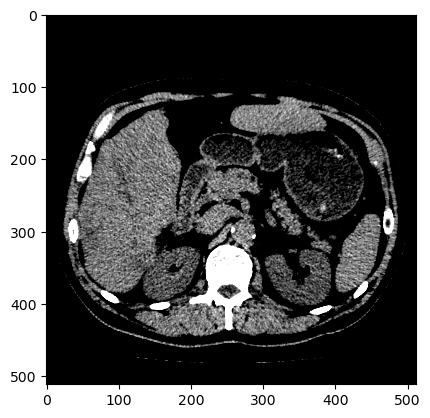

In [42]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)
plt.imshow(img, cmap="gray", vmin=0, vmax=100)
plt.show()

In [4]:
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]

### Exercise 2
Compute the average and standard deviation of the Hounsfield units found in the spleen in the training image. Do they correspond to the values found in the above figure?

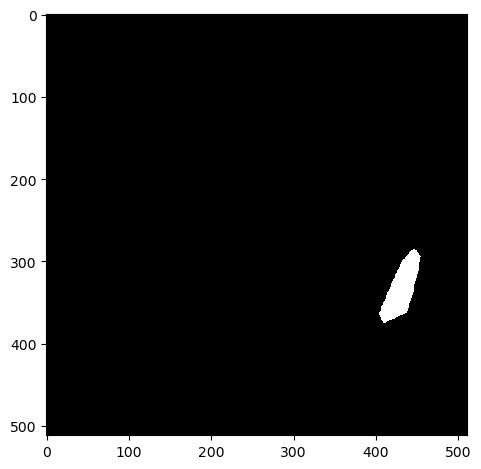

In [5]:
io.imshow(spleen_roi)

In [6]:
mu_spleen, std_spleen = np.mean(spleen_values), np.std(spleen_values)
print('The mean:', mu_spleen ,'| std:', std_spleen)

The mean: 49.48026905829597 | std: 14.9970794143059


### Exercise 3
Plot a histogram of the pixel values of the spleen. Does it look like they are Gaussian distributed?

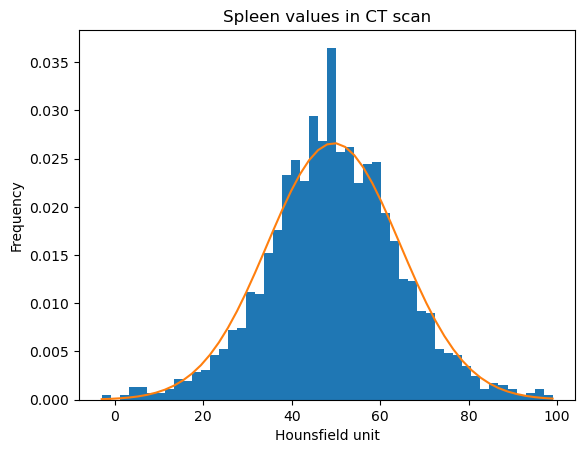

In [7]:
n, bins, patches = plt.hist(spleen_values, 50, density=1)
pdf_spleen = norm.pdf(bins, mu_spleen, std_spleen)
plt.plot(bins, pdf_spleen)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('Spleen values in CT scan')
plt.show()

### Exercise 4
Plot histograms and their fitted Gaussians of several of the tissues types. Do they all look like they are Gaussian distributed?

In [8]:
bone_roi = io.imread(in_dir + 'BoneROI.png')
# convert to boolean image
bone_mask = bone_roi > 0
bone_values = img[bone_mask]
mu_bone, std_bone = np.mean(bone_values), np.std(bone_values)

liver_roi = io.imread(in_dir + 'LiverROI.png')
liver_mask = liver_roi > 0
liver_values = img[liver_mask]
mu_liver, std_liver = np.mean(liver_values), np.std(liver_values)

fat_roi = io.imread(in_dir + 'FatROI.png')
fat_mask = fat_roi > 0
fat_values = img[fat_mask]
mu_fat, std_fat = np.mean(fat_values), np.std(fat_values)

kidney_roi = io.imread(in_dir + 'KidneyROI.png')
kidney_mask = kidney_roi > 0
kidney_values = img[kidney_mask]
mu_kidney, std_kidney = np.mean(kidney_values), np.std(kidney_values)


OR

In [9]:
def load_mask(mask_path):
    roi = io.imread(mask_path)
    mask = roi > 0
    return mask

def get_values(img, mask_path):
    mask = load_mask(mask_path)
    return img[mask]

def get_gaussian_distributions(values, min_hu = -200, max_hu = 1000):
    hu_range = np.arange(min_hu, max_hu, 1.0)
    mu = np.mean(values)
    std = np.std(values)
    pdf = norm.pdf(hu_range, mu, std)
    return pdf

paths = ['BoneROI.png', 'FatROI.png', 'KidneyROI.png', 'LiverROI.png', 'SpleenROI.png']
values = [get_values(img, in_dir + path) for path in paths]

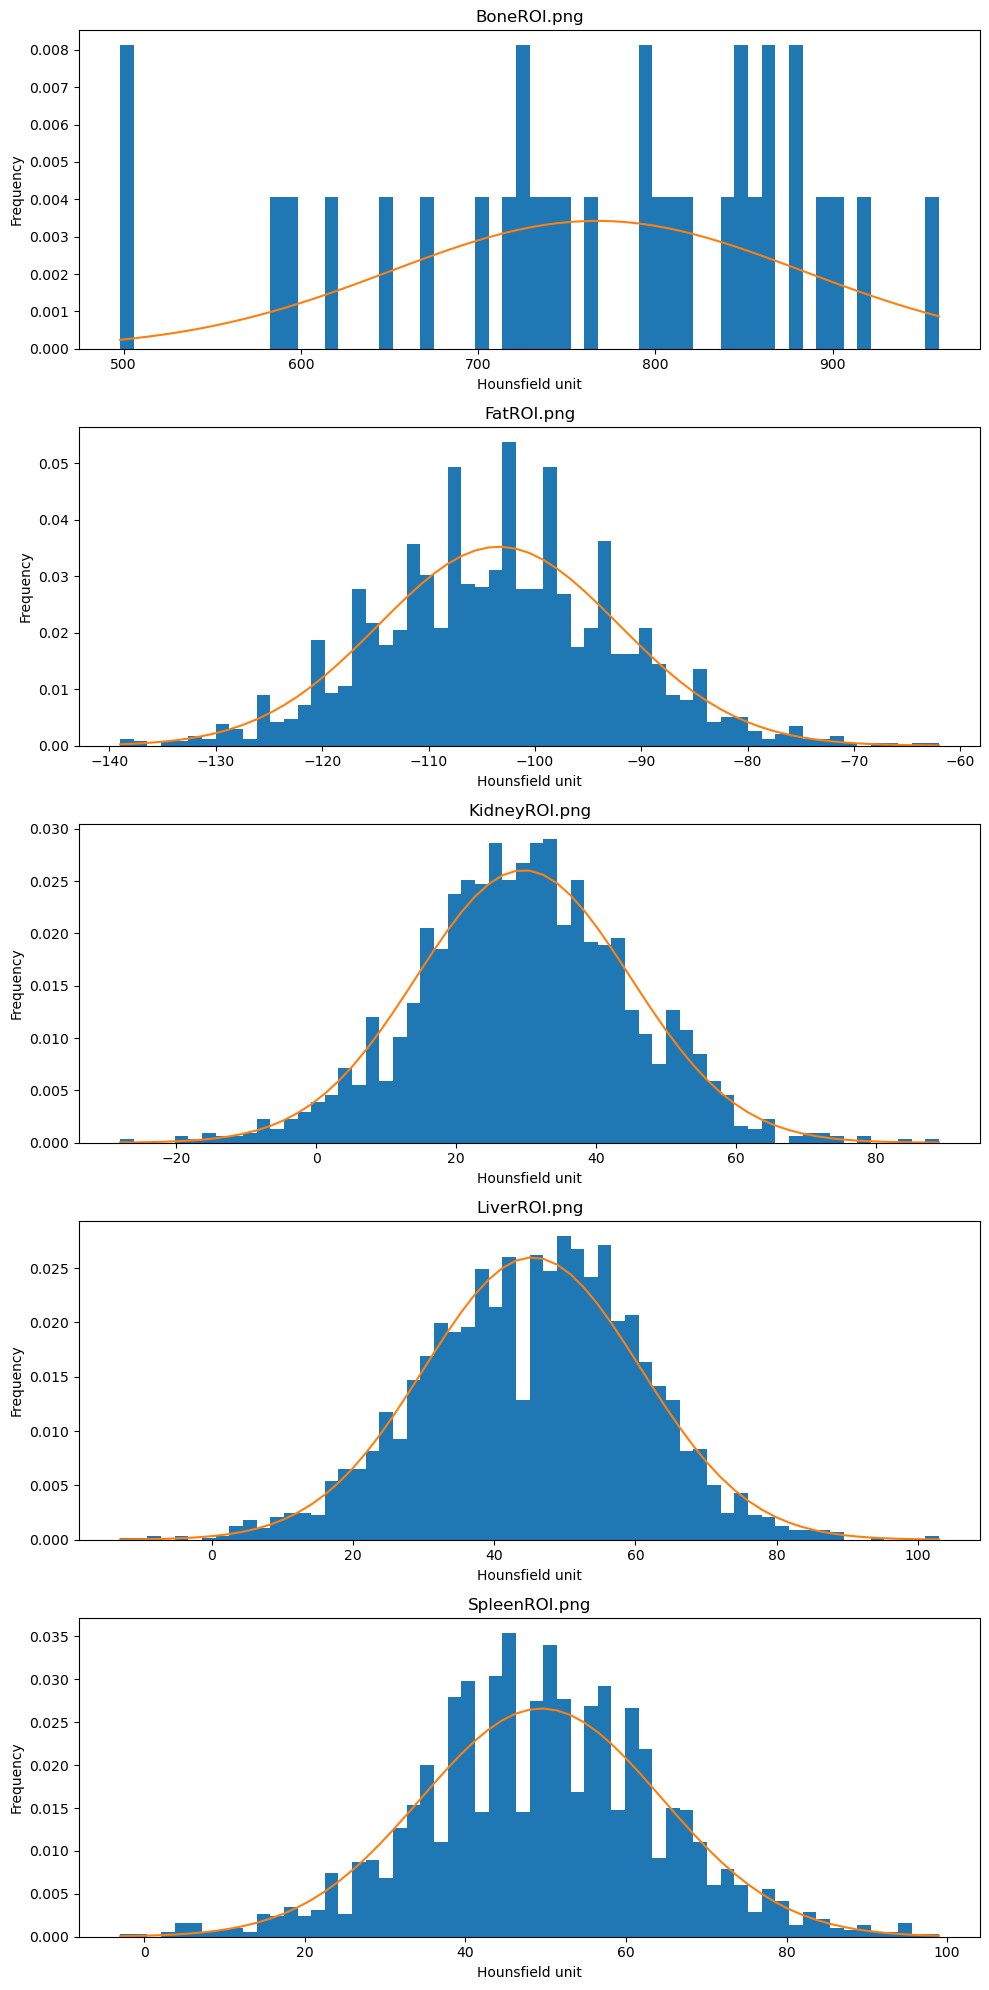

In [10]:
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

for ax, value, name in zip(axs, values, paths):
    n, bins, patches = ax.hist(value, 60, density=1)
    mu = np.mean(value)
    std = np.std(value)
    pdf = norm.pdf(bins, mu, std)
    ax.plot(bins, pdf)
    ax.set_xlabel('Hounsfield unit')
    ax.set_ylabel('Frequency')
    ax.set_title(name)

plt.tight_layout()
plt.show()

### Exercise 5
Plot the fitted Gaussians of bone, fat, kidneys, liver and spleen. What classes are easy to seperate and which classes are hard to seperate?

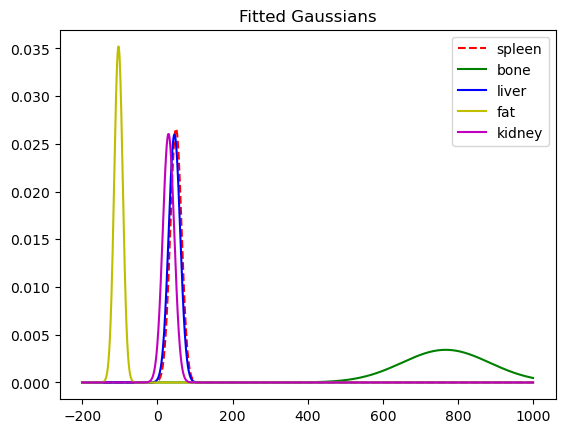

In [11]:
# Hounsfield unit limits of the plot
min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
pdf_spleen = norm.pdf(hu_range, mu_spleen, std_spleen)
pdf_bone = norm.pdf(hu_range, mu_bone, std_bone)
pdf_liver = norm.pdf(hu_range, mu_liver, std_liver)
pdf_fat = norm.pdf(hu_range, mu_fat, std_fat)
pdf_kidney = norm.pdf(hu_range, mu_kidney, std_kidney)
plt.plot(hu_range, pdf_spleen, 'r--', label="spleen")
plt.plot(hu_range, pdf_bone, 'g', label="bone")
plt.plot(hu_range, pdf_liver, 'b', label="liver")
plt.plot(hu_range, pdf_fat, 'y', label="fat")
plt.plot(hu_range, pdf_kidney, 'm', label="kidney")
plt.title("Fitted Gaussians")
plt.legend()
plt.show()

### Exercise 6
Define the classes that we aim at classifying. Perhaps some classes should be combined into one class?

- We can differenciate intensity-wise the fat, soft tissues (kidney, liver, spleen) and bone

## Minimum distance pixel classification
In the following, we will define four classes: background, fat, soft tissue and bone, where soft-tissue is a combination of the values of the spleen, liver and kidneys. We manually set the threshold for background to -200. So all pixels below -200 are set to background.

### Exercise 7
Compute the class ranges defining fat, soft tissue and bone.

In [12]:
# Mean
class_sorted = []
mean_classes = [np.mean(i) for i in values]
for i in range(len(paths)):
      class_sorted.append((paths[i], mean_classes[i]))
class_sorted.sort(key=lambda x: x[1])

midway_points = [(class_sorted[i][1] + class_sorted[i+1][1]) / 2 for i in range(len(class_sorted) - 1)]
print('Class: ',[i[0] for i in class_sorted])
print('Midway point:',midway_points)
print('')
ranges = [min_hu] + midway_points + [max_hu]
for i in range(len(midway_points)+1):
    print(class_sorted[i][0][:-7], 'is in the range [', ranges[i], ',', ranges[i+1], ']')

Class:  ['FatROI.png', 'KidneyROI.png', 'LiverROI.png', 'SpleenROI.png', 'BoneROI.png']
Midway point: [-36.8878870403638, 37.51035914125842, 47.44319208310482, 408.208884529148]

Fat is in the range [ -200 , -36.8878870403638 ]
Kidney is in the range [ -36.8878870403638 , 37.51035914125842 ]
Liver is in the range [ 37.51035914125842 , 47.44319208310482 ]
Spleen is in the range [ 47.44319208310482 , 408.208884529148 ]
Bone is in the range [ 408.208884529148 , 1000 ]


OR

In [41]:
vals_soft_tissue = np.concatenate(values[-3:])
soft_tissue_mean = np.mean(vals_soft_tissue)
bone_mean = np.mean(values[0])
fat_mean = np.mean(values[1])

print(f'Soft tissue mean: {soft_tissue_mean} - Bone mean: {bone_mean} - Fat mean: {fat_mean}')

t_fat_soft = (soft_tissue_mean + fat_mean)/2
t_bone_soft = (soft_tissue_mean + bone_mean)/2

print(f'Threshold between fat and soft tissue: {t_fat_soft}')
print(f'Threshold between bone and soft tissue: {t_bone_soft}')

Soft tissue mean: 43.00880789673501 - Bone mean: 766.9375 - Fat mean: -103.39037725533078
Threshold between fat and soft tissue: -30.190784679297884
Threshold between bone and soft tissue: 404.9731539483675


### Exercise 8
Create class images: fat_img, soft_img and bone_img representing the fat, soft tissue and bone found in the image.

In [14]:
t_background = -200
fat_img = (img > t_background) & (img <= t_fat_soft)
soft_img = (img > t_fat_soft) & (img <= t_bone_soft)
bone_img = (img > t_bone_soft) & (img <= 1000)


### Exercise 9
Visualize your classification result and compare it to the anatomical image in the start of the exercise. Does your results look plausible?


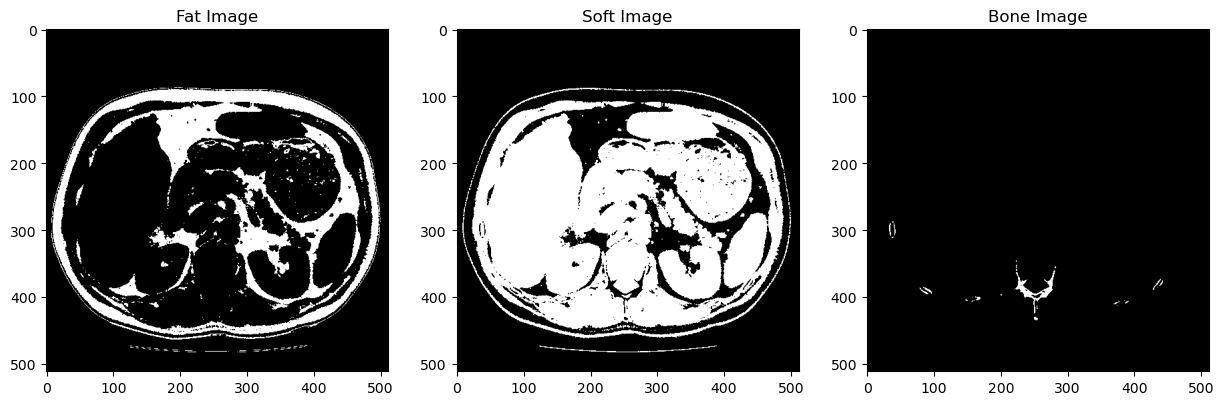

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(fat_img, cmap="gray")
plt.title('Fat Image')

plt.subplot(1, 3, 2)
plt.imshow(soft_img, cmap="gray")
plt.title('Soft Image')

plt.subplot(1, 3, 3)
plt.imshow(bone_img, cmap="gray")
plt.title('Bone Image')

plt.show()

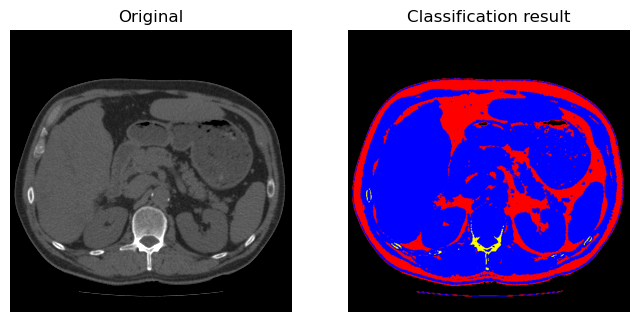

In [16]:
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

## Parametric pixel classification

### Exercise 9
Plot the fitted Gaussians of the training values and manually find the intersection between the curves.

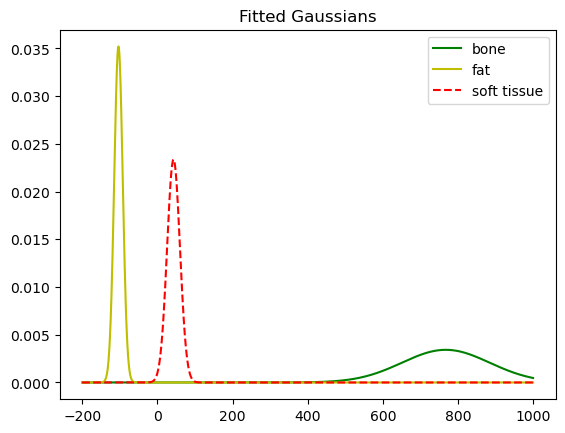

In [38]:
mu_soft = np.mean(vals_soft_tissue)
std_soft= np.std(vals_soft_tissue)

min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
pdf_bone = norm.pdf(hu_range, mu_bone, std_bone)
pdf_fat = norm.pdf(hu_range, mu_fat, std_fat)
pdf_soft_tissue = norm.pdf(hu_range, mu_soft, std_soft)
plt.plot(hu_range, pdf_bone, 'g', label="bone")
plt.plot(hu_range, pdf_fat, 'y', label="fat")
plt.plot(hu_range, pdf_soft_tissue, 'r--', label="soft tissue")
plt.title("Fitted Gaussians")
plt.legend()
plt.show()

### Exercise 10
Use the same technique as in exercise 7, 8 and 9 to visualize your classification results. Did it change compared to the minimum distance classifier?

In [39]:
test_value = [-45, -40, 139, 142]

for i in test_value:
    if norm.pdf(i, mu_fat, std_fat) > norm.pdf(i, mu_soft, std_soft):    
        print(f"For value {i} the class is fat")
    elif norm.pdf(i, mu_soft, std_soft) > norm.pdf(i, mu_bone, std_bone):
        print(f"For value {i} the class is soft tissue")
    else:
        print(f"For value {i} the class is bone")


For value -45 the class is fat
For value -40 the class is soft tissue
For value 139 the class is soft tissue
For value 142 the class is bone


### Exercise 11 - optimal class ranges using norm.pdf
Use norm.pdf to find the optimal class ranges between fat, soft tissue and bone.

In [40]:
# Automatic intersection Fat - Soft
for test_value in np.linspace(mu_fat, mu_soft, 1000):
    if norm.pdf(test_value, mu_soft, std_soft) > norm.pdf(test_value, mu_fat, std_fat):
        thres_fat_soft = test_value
        print(f"Fat - Soft threshold: {thres_fat_soft}")
        break

# Automatic intersection Soft - Bone
for test_value in np.linspace(mu_soft, mu_bone, 1000):
    if norm.pdf(test_value, mu_bone, std_bone) > norm.pdf(test_value, mu_soft, std_soft):
        thres_soft_bone = test_value
        print(f"Soft - Bone threshold: {thres_soft_bone}")
        break

Fat - Soft threshold: -44.332447709502425
Soft - Bone threshold: 140.83700953231136


## Object segmentation - The spleen finder

### Exercise 11
Inspect the values of the spleen as in exercise 3 and select a lower and upper threshold to create a spleen class range.

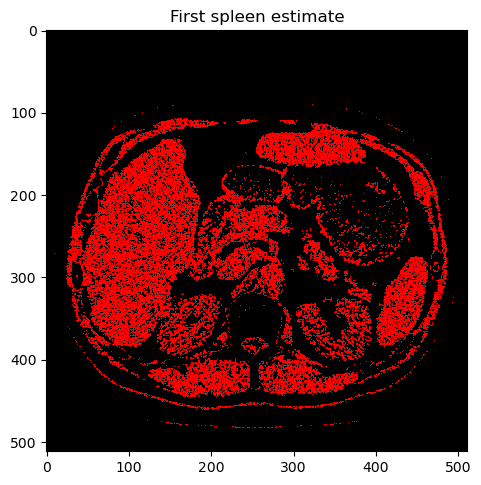

In [70]:
t_1 = 30
t_2 = 65

spleen_estimate = (img > t_1) & (img < t_2)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

### Exercise 12
Use the above morphological operations to seperate the spleen from other organs and close holes. Change the values where there are question marks to change the size of the used structuring elements.

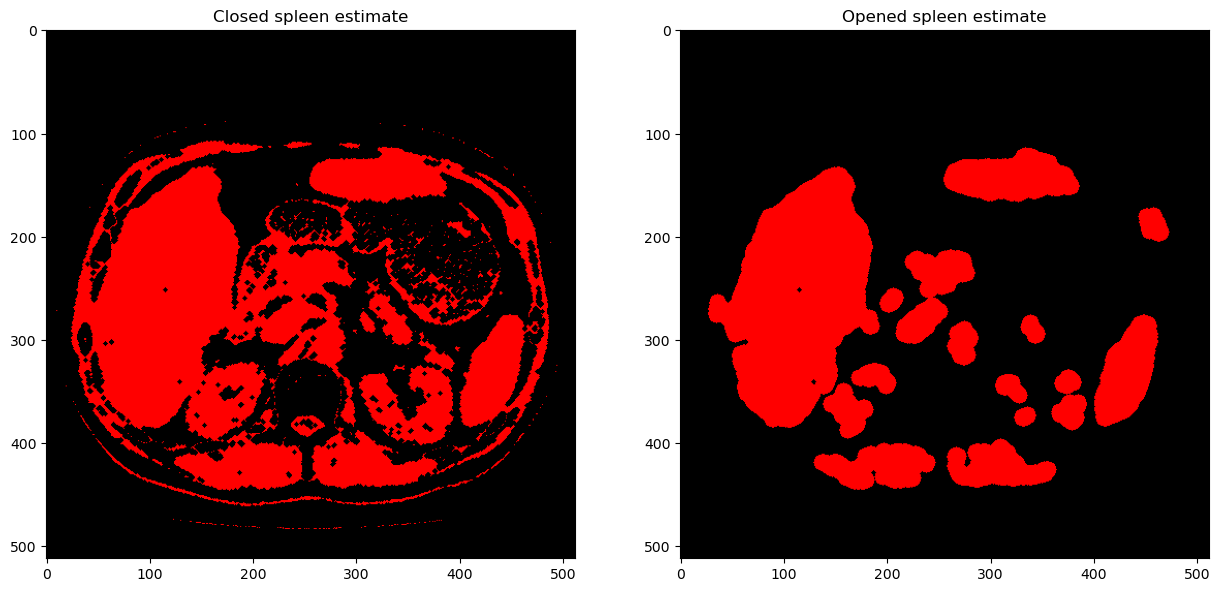

In [71]:
footprint = disk(2)
closed = binary_closing(spleen_estimate, footprint)
spleen_closed = color.label2rgb(closed)

footprint = disk(8)
opened = binary_opening(closed, footprint)
spleen_opened = color.label2rgb(opened)

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(spleen_closed, cmap="gray")
plt.title('Closed spleen estimate')

plt.subplot(1, 2, 2)
plt.imshow(spleen_opened, cmap="gray")
plt.title('Opened spleen estimate')


plt.show()

### Exercise 12 - BLOB analysis
Use the methods from BLOB analysis to compute BLOB features for every seperated BLOB in the image. You can for example start by:

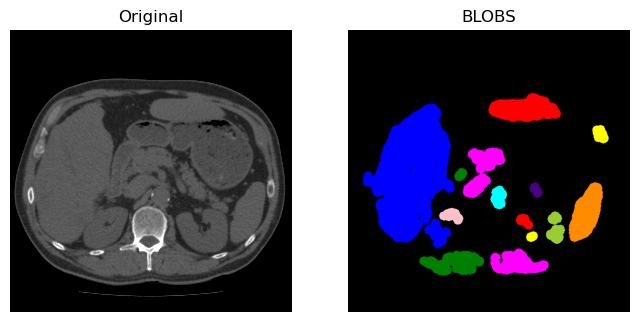

In [72]:
label_img = measure.label(opened)
im_blob = label2rgb(label_img)
show_comparison(img, im_blob, 'BLOBS')

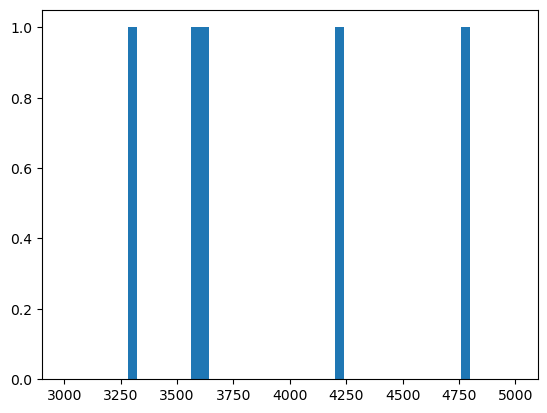

In [83]:
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=50, range=(3000, 5000))
plt.show()

### Exercise 13 - Based on area
Inspect the labeled image and validate the success of separating the spleen from the other objects. If it is connected (have the same color) to another organ, you should experiment with the kernel sizes in the morphological operations.

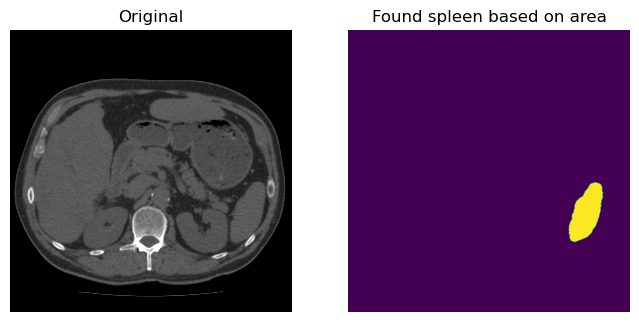

In [85]:
min_area = 4000
max_area = 4500

# Create a copy of the label_img
label_img_filter = label_img.copy()
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img, i_area, 'Found spleen based on area')

### Exercise 14 - Based on perimeter
Extend the method above to include several BLOB features. For example area and perimeter. Find the combination of features and feature value limits that will result in only the spleen remaining.

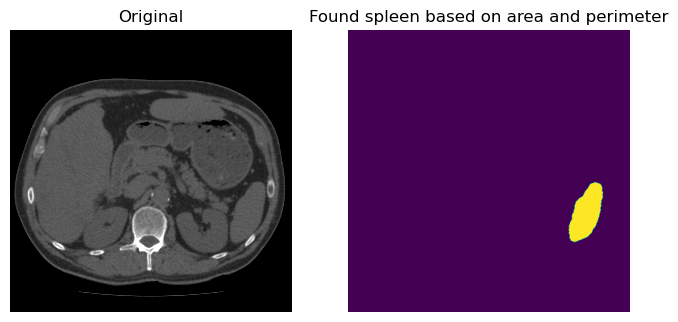

In [90]:
min_area = 2000
max_area = 10000
min_perimeter = 250
max_perimeter = 300

# Create a copy of the label_img
label_img_filter = label_img.copy()
for region in region_props:
	# Find the areas that do not fit our criteria
	crit1 = region.area > max_area or region.area < min_area
	crit2 = region.perimeter > max_perimeter or region.perimeter < min_perimeter
	if crit1 or crit2:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
  
# Create binary image from the filtered label image
i_area_perimeter = label_img_filter > 0
show_comparison(img, i_area_perimeter, 'Found spleen based on area and perimeter')

### Exercise 15
Create a function spleen_finder(img) that takes as input a CT image and returns a binary image, where the pixels with value 1 represent the spleen and the pixels with value 0 everything else.

In [140]:
def spleen_finder(img, plot=True):
    t_1, t_2 = 30, 65

    spleen_estimate = (img > t_1) & (img < t_2)

    footprint = disk(2)
    closed = binary_closing(spleen_estimate, footprint)

    footprint = disk(5)
    opened = binary_opening(closed, footprint)
    label_img = measure.label(opened)
    region_props = measure.regionprops(label_img)
    
    min_area = 3700
    max_area = 4900
    min_perimeter = 150
    max_perimeter = 320

    # Create a copy of the label_img
    label_img_filter = label_img.copy()
    for region in region_props:
        # Find the areas that do not fit our criteria
        crit1 = region.area > max_area or region.area < min_area
        crit2 = region.perimeter > max_perimeter or region.perimeter < min_perimeter
        if crit1 or crit2:
            # set the pixels in the invalid areas to background
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0
    
    # Create binary image from the filtered label image
    i_area_perimeter = label_img_filter > 0
    if plot:
        show_comparison(img, i_area_perimeter, 'Found spleen based on area and perimeter')
    
    return i_area
    

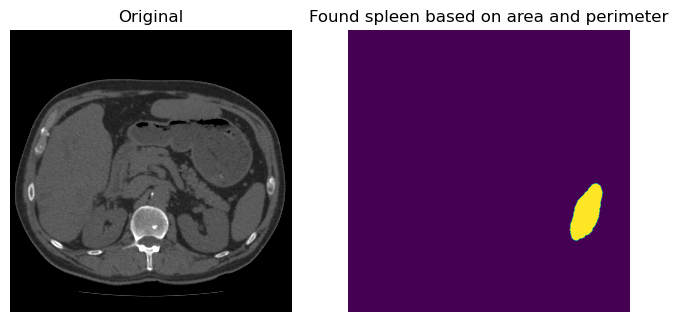

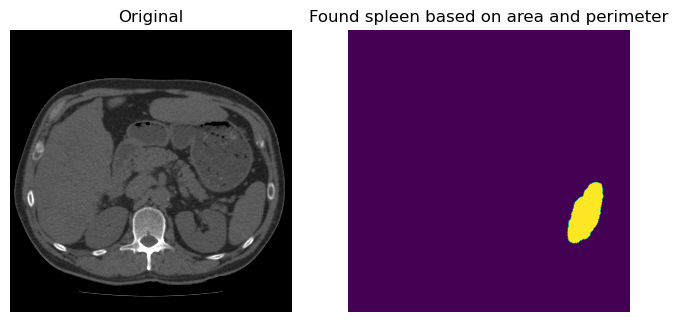

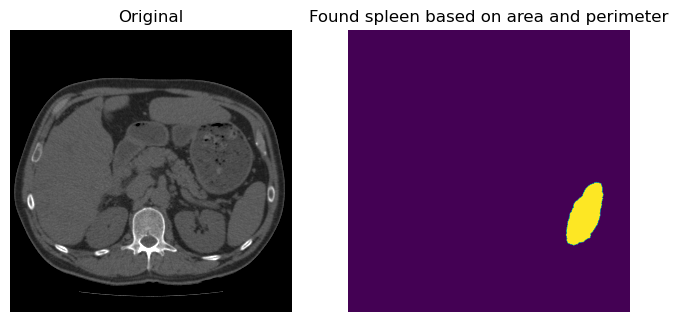

In [141]:
in_dir = "data/"
val_set = ['Validation1.dcm', 'Validation2.dcm', 'Validation3.dcm']

for i in val_set:
    ct = dicom.read_file(in_dir + i)
    img = ct.pixel_array
    i_area = spleen_finder(img)
    

## DICE Score
We would like evaluate how good we are at finding the spleen by comparing our found spleen with ground truth annotations of the spleen. The **DICE score** (also called the DICE coefficient or the DICE distance) is a standard method of comparing one segmentation with another segmentation.

If segmentation one is called `X` and the second segmentation called `Y`. The DICE score is computed as:

$$
\text{DICE} = \frac{2 |X \cap Y|}{|X| + |Y|}
$$

where $|X \cap Y|$ is the area (in pixels) of the overlap of the two segmentations and is $|X| + |Y|$ the area of the union of the two segmentation. This can be visualized as:

In [142]:
def DICE_score(img, ground_truth_img):
    i_area = spleen_finder(img, plot=False)
    gt_bin = ground_truth_img > 0
    dice_score = 1 - distance.dice(i_area.ravel(), gt_bin.ravel())
    return dice_score

for i in val_set:
    ct = dicom.read_file(in_dir + i)
    img = ct.pixel_array
    ground_truth_img = io.imread(in_dir + i[:-4] + '_spleen.png')
    dice_score = DICE_score(img, ground_truth_img)
    print("DICE score for", i,f"is {dice_score}")
    


DICE score for Validation1.dcm is 0.9313380281690141
DICE score for Validation2.dcm is 0.9629854984281513
DICE score for Validation3.dcm is 0.9605434022575168


## Testing on an independent test set

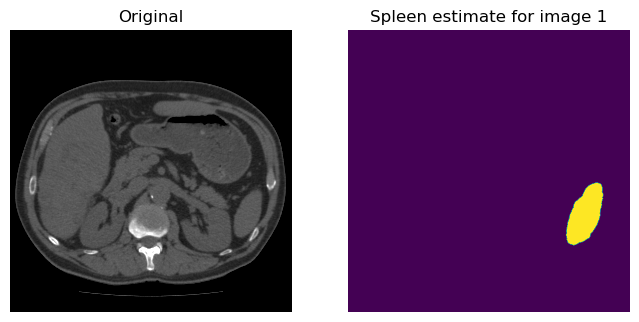

Dice score for test image 1: 0.773


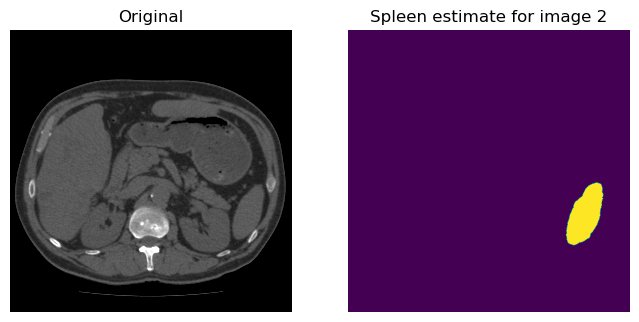

Dice score for test image 2: 0.863


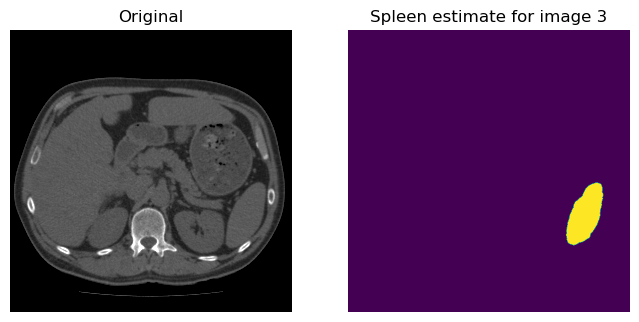

Dice score for test image 3: 0.936


In [148]:
for i in range(1, 4):
    path = f"data/Test{i}.dcm"
    ct = dicom.read_file(path)
    img = ct.pixel_array
    spleen_estimate = spleen_finder(img, plot=False)
    spleen_gt = load_mask(f"data/Test{i}_spleen.png")
    dice = DICE_score(spleen_estimate, spleen_gt)
    show_comparison(img, spleen_estimate, f"Spleen estimate for image {i}")
    print(f"Dice score for test image {i}: {dice:.3f}")